**Prepared Dataset and The Other Stuffs**
---
Menyiapkan dataset dan semua library yang dibutuhkan


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub 
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pathlib
from os import getcwd
%matplotlib inline

In [ ]:
#pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import splitfolders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#input_file = '/content/drive/MyDrive/DATASETS'
#output_file = '/content/drive/MyDrive/DATASETS SPLITTED'

***Split to Train, Test, Val and Preprocessed Dataset***
---
Dataset di split ke dalam train test dan val, dengan rasio 0.8, 0.1, 0.1 . 
Juga dilakukan shuffle, augmentasi, dan lain lain.


In [ ]:
#splitfolders.ratio(input_file, output=output_file, seed=123, ratio=(.8, .1, .1), group_prefix=None)

In [3]:
base_dir='/content/drive/MyDrive/DATASETS SPLITTED'
train_dir= os.path.join(base_dir, 'train')
val_dir= os.path.join(base_dir, 'val')
test_dir= os.path.join(base_dir, 'test')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (300, 300)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 7105 files belonging to 13 classes.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 885 files belonging to 13 classes.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 897 files belonging to 13 classes.


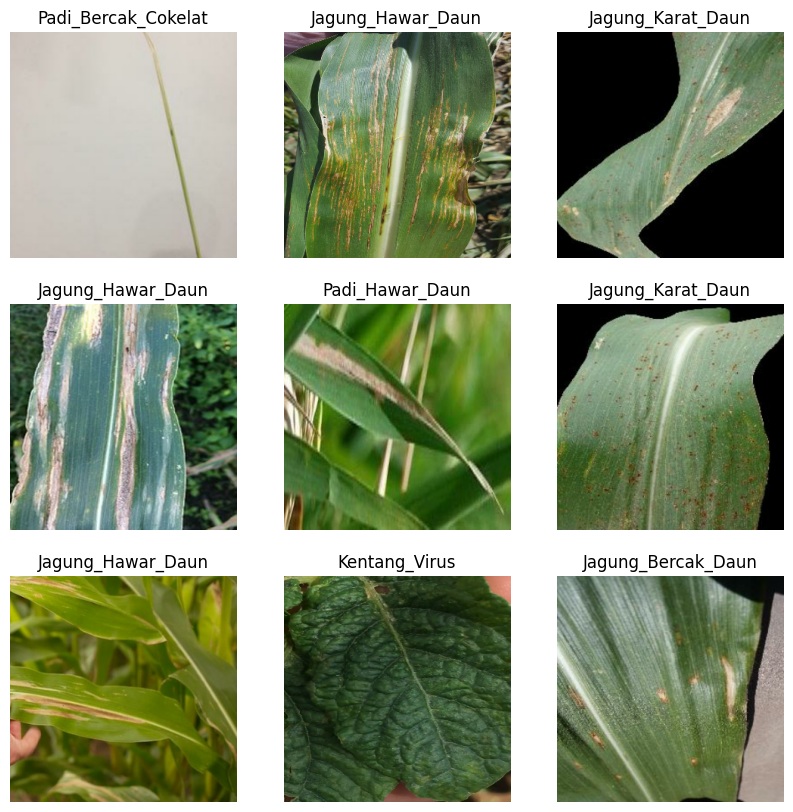

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

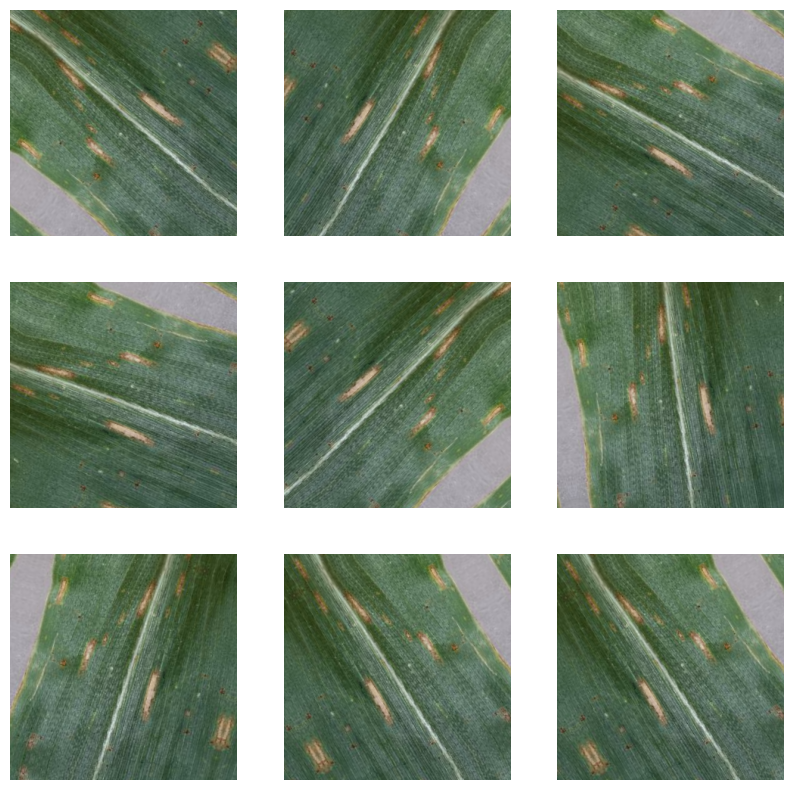

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

**Transfer Learning #1**
---
Menggunakan pretrained model untuk ekstraksi fitur. 

---


"The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features".

In [12]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB3(input_shape=(300,300,3), include_top=False, weights='imagenet')

43941136/43941136 [==============================] - 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1536)


In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 300, 300, 3)  0           ['normalization[0][0

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [30]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 rescaling_3 (Rescaling)     (None, 10, 10, 1536)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          442400    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          18496     
                                                      

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
#Evaluate Our Final Model Architectures
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


In [34]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds, callbacks=[callback])

Epoch 1/10
223/223 [==============================] - 61s 267ms/step - loss: 0.4670 - accuracy: 0.8245 - val_loss: 0.4583 - val_accuracy: 0.8237
Epoch 2/10
223/223 [==============================] - 64s 280ms/step - loss: 0.4517 - accuracy: 0.8204 - val_loss: 0.4428 - val_accuracy: 0.8260
Epoch 3/10
223/223 [==============================] - 61s 269ms/step - loss: 0.4381 - accuracy: 0.8322 - val_loss: 0.4302 - val_accuracy: 0.8316
Epoch 4/10
223/223 [==============================] - 64s 277ms/step - loss: 0.4154 - accuracy: 0.8394 - val_loss: 0.4180 - val_accuracy: 0.8350
Epoch 5/10
223/223 [==============================] - 64s 278ms/step - loss: 0.4084 - accuracy: 0.8424 - val_loss: 0.4164 - val_accuracy: 0.8271
Epoch 6/10
223/223 [==============================] - 60s 264ms/step - loss: 0.3990 - accuracy: 0.8467 - val_loss: 0.3908 - val_accuracy: 0.8508
Epoch 7/10
223/223 [==============================] - 61s 266ms/step - loss: 0.3908 - accuracy: 0.8507 - val_loss: 0.3859 - val_ac

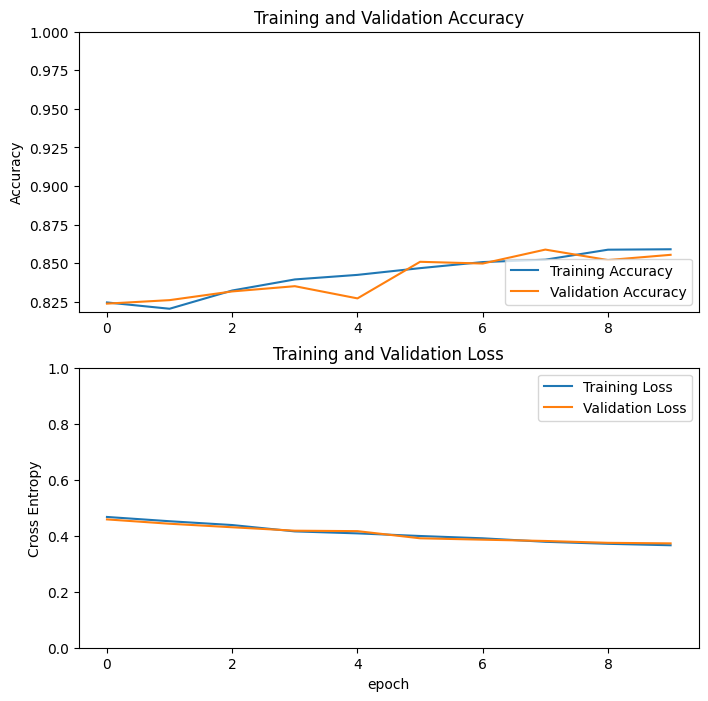

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

29/29 [==============================] - 116s 3s/step - loss: 0.4063 - accuracy: 0.8450
Test accuracy : 0.8450390100479126


In [37]:
test_data = list(test_ds)
features = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
targets = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])

In [38]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [39]:
predictions = probability_model.predict(features)

29/29 [==============================] - 10s 186ms/step


In [40]:
predictions[0]

array([0.06803657, 0.06803651, 0.06804023, 0.06803651, 0.18274315,
       0.06884159, 0.06803653, 0.06804624, 0.06803651, 0.06803651,
       0.06803656, 0.06803651, 0.06803651], dtype=float32)

In [41]:
np.argmax(predictions[0])

4

In [42]:
targets[0]

4

Predictions:
 [[0.06803657 0.06803651 0.06804023 ... 0.06803656 0.06803651 0.06803651]
 [0.06885774 0.06885843 0.06885874 ... 0.06887758 0.07415423 0.06958791]
 [0.13561615 0.09695102 0.07010335 ... 0.0697332  0.06973288 0.06973289]
 ...
 [0.12461171 0.10655468 0.0698989  ... 0.06989375 0.06989344 0.06989344]
 [0.06850959 0.06854184 0.06850768 ... 0.06855585 0.06876113 0.07337527]
 [0.10340173 0.11033454 0.0723665  ... 0.07723716 0.07038362 0.07040788]]
Labels:
 [ 4  9  0  4  1  0  1 11  9  9 10  4 11  0  1  3  9  2  0  5  2  2  4 12
  1  6  8  8 12 10  3  1  6 12  6  1  9  2  1  2 12  0 11  5 10  3  9  0
 11  3  2  8  7  5  7 12  1  8  3  3  7  4  3  2  5  1 12  3  7  0  3  8
  6  0 10  7  3 11  3  5 12 11  3  5 12  4  4  2  5 11  0  7  7  4  0 12
  2 11  7  6  8 10  2 12  1 11  5  3  8 11  3  3 12  1  2  2 11  3  2  2
 11 12  4  9  7  8  2  3  1  6 10  6  1  3  9  9  8  0  3 12  2 10  1  9
  4 12  3 10  1  6  1  7 10  2  8  4 12  8  1  2  2  9  2  2  1  9  2  4
 11  7  5  1 10 11  9 

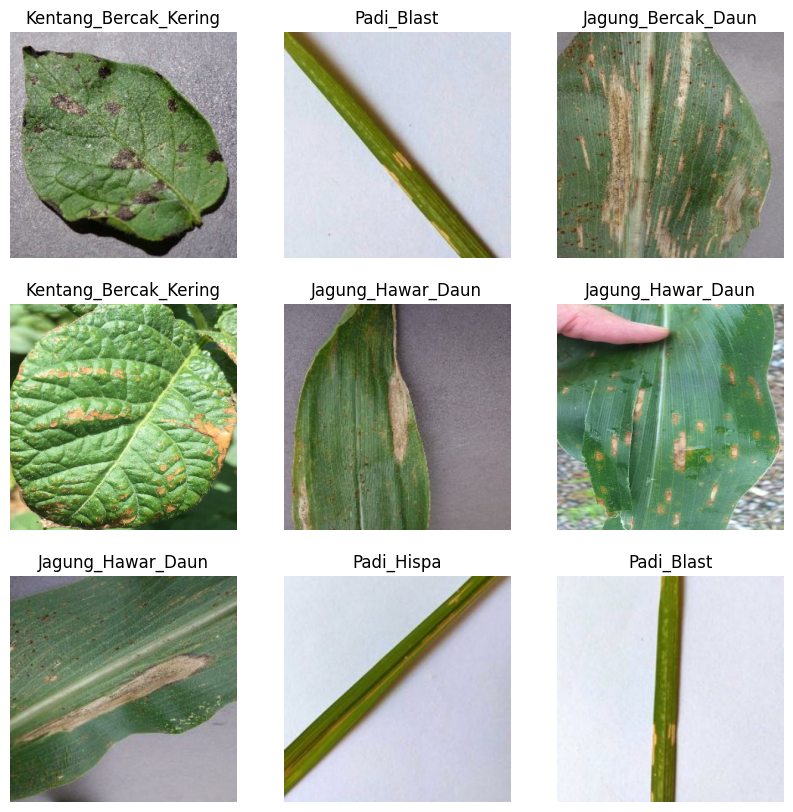

In [46]:
print('Predictions:\n', predictions)
print('Labels:\n', targets)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(features[i].astype("uint8"))
 
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

**Transfer Learning #2**
---
Fine tuning dengan pre trained model
---
"In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on".



**ANOTHER**

In [44]:
base_model.trainable = True

In [47]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  385


In [48]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [50]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 rescaling_4 (Rescaling)     (None, 10, 10, 1536)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 32)          442400    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 64)          18496     
                                                      

In [55]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [56]:
#Evaluate Our Final Model Architectures
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


In [57]:
history_ft = model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds, callbacks=[callback])

Epoch 1/15
223/223 [==============================] - 191s 546ms/step - loss: 1.8861 - accuracy: 0.3673 - val_loss: 1.1630 - val_accuracy: 0.5401
Epoch 2/15
223/223 [==============================] - 121s 534ms/step - loss: 1.0927 - accuracy: 0.5769 - val_loss: 0.9144 - val_accuracy: 0.6463
Epoch 3/15
223/223 [==============================] - 118s 523ms/step - loss: 0.8869 - accuracy: 0.6652 - val_loss: 0.7450 - val_accuracy: 0.6734
Epoch 4/15
223/223 [==============================] - 117s 518ms/step - loss: 0.6814 - accuracy: 0.7500 - val_loss: 0.5603 - val_accuracy: 0.7898
Epoch 5/15
223/223 [==============================] - 118s 521ms/step - loss: 0.5022 - accuracy: 0.7882 - val_loss: 0.4154 - val_accuracy: 0.7898
Epoch 6/15
223/223 [==============================] - 116s 511ms/step - loss: 0.4352 - accuracy: 0.7893 - val_loss: 0.4472 - val_accuracy: 0.7831
Epoch 7/15
223/223 [==============================] - 119s 527ms/step - loss: 0.4161 - accuracy: 0.7958 - val_loss: 0.4151 -

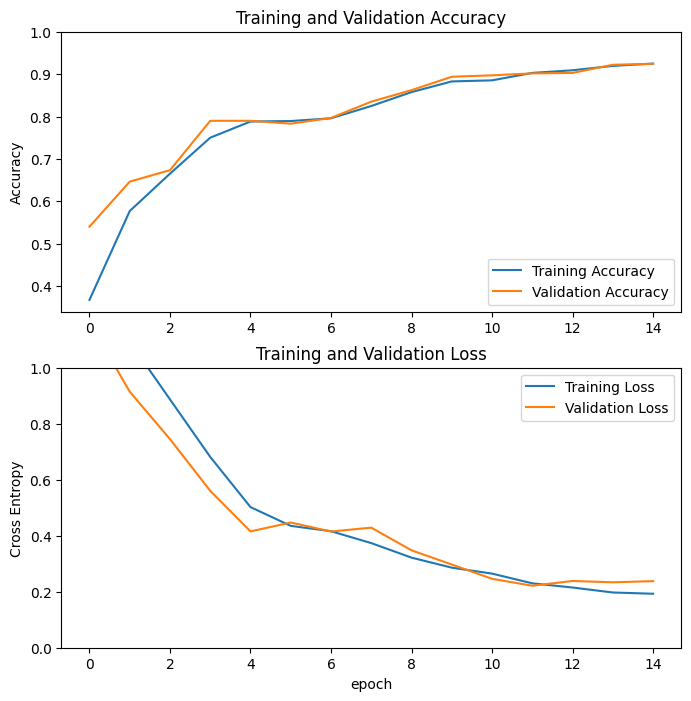

In [58]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [59]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

29/29 [==============================] - 8s 208ms/step - loss: 0.2154 - accuracy: 0.9320
Test accuracy : 0.9319955110549927


In [60]:
test_data = list(test_ds)
features = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
targets = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])

In [61]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [62]:
predictions = probability_model.predict(features)

29/29 [==============================] - 10s 190ms/step


In [64]:
predictions[0]

array([0.06795578, 0.06795578, 0.06795578, 0.06795578, 0.06795578,
       0.06795593, 0.06806785, 0.18441841, 0.06795578, 0.06795578,
       0.06795578, 0.06795578, 0.06795578], dtype=float32)

In [65]:
np.argmax(predictions[0])

7

In [66]:
targets[0]

7

Predictions:
 [[0.06795578 0.06795578 0.06795578 ... 0.06795578 0.06795578 0.06795578]
 [0.0679978  0.18448448 0.06796295 ... 0.06795259 0.06795278 0.06795258]
 [0.0680678  0.06799474 0.06799251 ... 0.06813119 0.0679922  0.06801014]
 ...
 [0.06794993 0.0679634  0.06794859 ... 0.0679826  0.0679486  0.06794859]
 [0.06795076 0.06796422 0.0679488  ... 0.06798308 0.06794882 0.0679488 ]
 [0.06799729 0.06801008 0.18376106 ... 0.0679876  0.06798913 0.06798765]]
Labels:
 [ 7  1  4  1  8  2  4  7  4  8 11 11  1  8  3  8  2  3  1 12  6  4  1  8
  6  0  3  9  7  5 12  4  3 10  0  1  1  3 11 10  4  1  2 11 12  5  9  2
  4 12  9  3  1  1  2  4  9  3  3  5  5  1  3  8 12 11  3  0 11  5  9  0
  1  2 11  1 12 12 10  4 12  3 12 10  8  6  9  2 10  5  5  4  6 11  7  1
  3  7  1  8  8 12  1  3  6  3  5 11 10  1 10  5  3  1  0  0  3  2 12  6
  2  3  1  2  4  1  8  3  1  1 12  8  2  8 10  8  9  2  6 10  3  5  7  6
 10  1  1  1  5  8  3  8  0  4 12  2  7  2  1  2  3  1  2  1  7 11  1 10
  8 11  3  2  0  0  3 

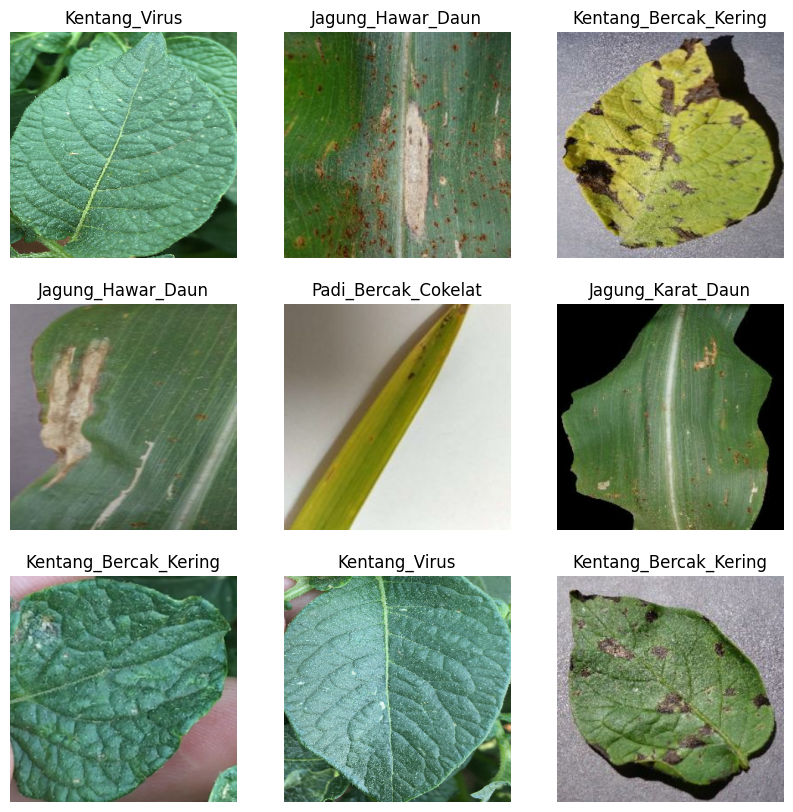

In [67]:
print('Predictions:\n', predictions)
print('Labels:\n', targets)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(features[i].astype("uint8"))
 
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

Saving Healthy400.png to Healthy400.png
1/1 [==============================] - 5s 5s/step
number label 6
name label
Kentang Sehat


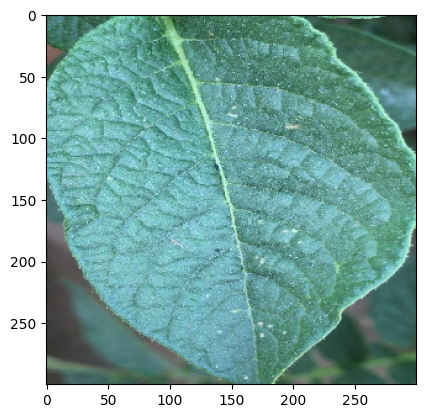

In [92]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import keras.utils as image
from keras.utils import load_img, img_to_array


uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
  prediction = probability_model.predict(images)
  classes=np.argmax(prediction)

  plt.imshow(img)
  print("number label", classes)

  print("name label")
  if classes==0:
    print("Jagung Bercak Daun")
  elif classes==1:
    print("Jagung Hawar Daun")
  elif classes==2:
    print("Jagung Karat Daun")
  elif classes==3:
    print("Jagung Sehat")
  elif classes==4:
    print("Kentang Bercak Kering")
  elif classes==5:
    print("Kentang Busuk Daun")
  elif classes==6:
    print("Kentang Sehat")
  elif classes==7:
    print("Kentang Virus")
  elif classes==8:
    print("Padi Bercak Cokelat")
  elif classes==9:
    print("Padi Blast")
  elif classes==10:
    print("Padi Hawar Daun")
  elif classes==11:
    print("Padi Hispa")
  elif classes==12:
    print("Padi Sehat")
  